In [2]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("/content/drive/MyDrive/dataset_Transfer_learning"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 4 directories and 0 images in '/content/drive/MyDrive/dataset_Transfer_learning'.
There are 2 directories and 0 images in '/content/drive/MyDrive/dataset_Transfer_learning/dataset_100sr_20tau'.
There are 10 directories and 0 images in '/content/drive/MyDrive/dataset_Transfer_learning/dataset_100sr_20tau/training_set'.
There are 0 directories and 60 images in '/content/drive/MyDrive/dataset_Transfer_learning/dataset_100sr_20tau/training_set/sags'.
There are 0 directories and 60 images in '/content/drive/MyDrive/dataset_Transfer_learning/dataset_100sr_20tau/training_set/interruptions'.
There are 0 directories and 60 images in '/content/drive/MyDrive/dataset_Transfer_learning/dataset_100sr_20tau/training_set/osc_transients'.
There are 0 directories and 60 images in '/content/drive/MyDrive/dataset_Transfer_learning/dataset_100sr_20tau/training_set/flickers'.
There are 0 directories and 60 images in '/content/drive/MyDrive/dataset_Transfer_learning/dataset_100sr_20tau/training_set

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "/content/drive/MyDrive/dataset_Transfer_learning/dataset_256sr_20tau/training_set"
test_dir = "/content/drive/MyDrive/dataset_Transfer_learning/dataset_256sr_20tau/testing_set"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                              target_size=IMAGE_SHAPE,
                              batch_size=BATCH_SIZE,
                              class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                        target_size=IMAGE_SHAPE,
                        batch_size=BATCH_SIZE,
                        class_mode="categorical")

Training images:
Found 600 images belonging to 10 classes.
Testing images:
Found 2000 images belonging to 10 classes.


In [5]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import tensorflow as tf
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [6]:
import tensorflow_hub as hub
from tensorflow.keras import layers

In [7]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

In [8]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                        trainable=False, # freeze the underlying patterns
                        name='feature_extraction_layer',
                        input_shape=IMAGE_SHAPE+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model

In [9]:
# Create model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [10]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [11]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                  epochs=10,
                  steps_per_epoch=len(train_data_10_percent),
                  validation_data=test_data,
                  validation_steps=len(test_data),
                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                  callbacks=[create_tensorboard_callback(dir_name="/content/drive/MyDrive/tensorflow_hub", # save experiment logs here
                                      experiment_name="dataset_256sr_20tau_resnet50V2")]) # name of log files

Saving TensorBoard log files to: /content/drive/MyDrive/tensorflow_hub/dataset_256sr_20tau_resnet50V2/20221015-085231
Epoch 1/10
19/19 [==============================] - 802s 43s/step - loss: 1.4667 - accuracy: 0.5533 - val_loss: 0.8751 - val_accuracy: 0.7870
Epoch 2/10
19/19 [==============================] - 5s 267ms/step - loss: 0.6564 - accuracy: 0.8400 - val_loss: 0.5880 - val_accuracy: 0.8350
Epoch 3/10
19/19 [==============================] - 5s 263ms/step - loss: 0.4373 - accuracy: 0.9133 - val_loss: 0.4554 - val_accuracy: 0.8705
Epoch 4/10
19/19 [==============================] - 5s 271ms/step - loss: 0.3357 - accuracy: 0.9183 - val_loss: 0.3821 - val_accuracy: 0.9015
Epoch 5/10
19/19 [==============================] - 5s 275ms/step - loss: 0.2821 - accuracy: 0.9467 - val_loss: 0.3373 - val_accuracy: 0.9135
Epoch 6/10
19/19 [==============================] - 5s 268ms/step - loss: 0.2537 - accuracy: 0.9517 - val_loss: 0.3124 - val_accuracy: 0.9140
Epoch 7/10
19/19 [============

In [12]:
# If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

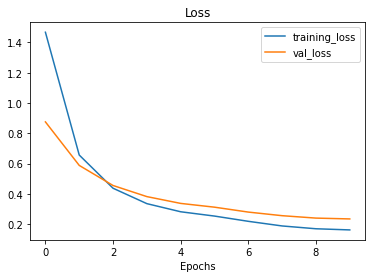

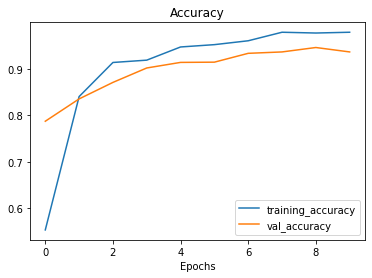

In [13]:
plot_loss_curves(resnet_history)

In [14]:
# Save the trained model
model_title = "Transfer_learning_dataset_256sr_20tau_Resnet.h5"
resnet_model.save('/content/drive/MyDrive/Transfer_learning_saved_models/' + model_title)